In [1]:
import base64

import matplotlib.pyplot as plt
import numpy as np
import requests

from aaron_rw_tfrecord import read_tfrecord
from aaron_simple_example import *

plt.show()

# tf.enable_eager_execution()


In [4]:
infile = '/tmp/data/mnist/tmpPivLUi/train_shuffled-00000-of-00001.gz'
img = read_tfrecord(infile)
img.shape

(28, 28, 1)

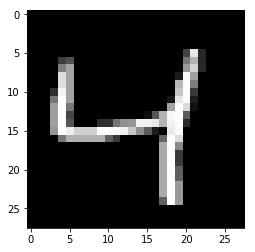

In [5]:
def display_image(img):
    """
    Coverts a 1-channel np.ndarray to 3-channel and displays it
    using matplotlib
    """
    assert isinstance(img, np.ndarray), type(img)

    stacked_img = np.stack((np.squeeze(img), ) * 3, axis=-1)
    assert stacked_img.shape == (28, 28, 3), stacked_img.shape

    plt.imshow(stacked_img, cmap=plt.get_cmap('gray'))

display_image(img)

In [6]:
# Open and read image as bitstring
image_infile = '/Users/aaron/Desktop/mnist-test-4.png'
with open(image_infile, 'rb') as f:
    input_image = f.read()

print("Raw bitstring: " + str(input_image[:10]) + " ... " + str(input_image[-10:]))

Raw bitstring: �PNG

   ...   IEND�B`�


In [7]:
# Encode image in b64
encoded_input_string = base64.b64encode(input_image)
input_string = encoded_input_string.decode("utf-8")
print("Base64 encoded string: " + input_string[:10] + " ... " + input_string[-10:])

Base64 encoded string: iVBORw0KGg ... lFTkSuQmCC


In [8]:
try:
    url = 'http://127.0.0.1:8500/v1/models/mnist:predict'
    data ={
          "inputs": input_string
        }
    r = requests.post(url, json=data)
    r, r.content
except requests.exceptions.ConnectionError:
    print('ConnectionError')

ConnectionError


In [9]:
# inspect img

In [10]:
img.shape

(28, 28, 1)

In [11]:
type(img)

numpy.ndarray

In [12]:
img_784 = np.reshape(img, (1, 784))
img_784.shape

(1, 784)

In [13]:
# png to ndarray

In [14]:
import imageio

im = imageio.imread(image_infile)
print(im.shape)

(252, 255, 4)


In [15]:
import matplotlib

stacked_img = np.stack((np.squeeze(img), ) * 3, axis=-1)

image_outfile = 'mnist-4-outfile.png'
matplotlib.image.imsave(image_outfile, stacked_img)

In [16]:
!pwd

/Users/aaron/Documents/github/transform/examples


In [17]:
!ls *.png

mnist-4-outfile.png


In [18]:
# png to ndarray

In [19]:
im = imageio.imread(image_outfile)
print(im.shape)

(28, 28, 4)


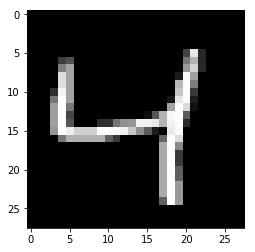

In [20]:
plt.imshow(im, cmap=plt.get_cmap('gray'))

In [21]:
# remove 4th dimension which would be alpha

In [22]:
# converts shape (28, 28, 4) to (28, 28, 3)
im_w_no_alpha_dimen = im[:,:,:3]
im_w_no_alpha_dimen.shape

(28, 28, 3)

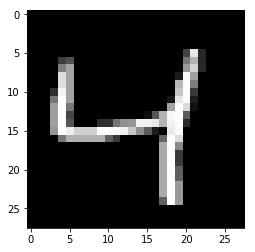

In [23]:
plt.imshow(im_w_no_alpha_dimen, cmap=plt.get_cmap('gray'))

In [24]:
# convert back to 1 channel

In [25]:
im_bw = im_w_no_alpha_dimen[:,:,0]
im_bw.shape

(28, 28)

In [26]:
restacked_im = np.stack((np.squeeze(im_bw), ) * 3, axis=-1)
restacked_im.shape

(28, 28, 3)

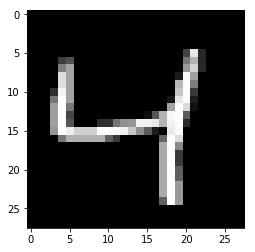

In [27]:
plt.imshow(restacked_im, cmap=plt.get_cmap('gray'))

In [28]:
im_bw_flat = np.reshape(im_bw, (1, -1))
im_bw_flat.shape

(1, 784)

In [29]:
im_bw_flat.astype('float').dtype

dtype('float64')

In [30]:
# call tensorflow-serving

In [31]:
import sys
import threading

import grpc
import tensorflow as tf
import imageio
import numpy

from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc

In [32]:
with open('mnist-4-outfile.png', 'rb') as f:
    image_byte_str = f.read()

In [33]:
class _ResultCounter(object):
  """Counter for the prediction results."""

  def __init__(self, num_tests, concurrency):
    self._num_tests = num_tests
    self._concurrency = concurrency
    self._error = 0
    self._done = 0
    self._active = 0
    self._condition = threading.Condition()

  def inc_error(self):
    with self._condition:
      self._error += 1

  def inc_done(self):
    with self._condition:
      self._done += 1
      self._condition.notify()

  def dec_active(self):
    with self._condition:
      self._active -= 1
      self._condition.notify()

  def get_error_rate(self):
    with self._condition:
      while self._done != self._num_tests:
        self._condition.wait()
      return self._error / float(self._num_tests)

  def throttle(self):
    with self._condition:
      while self._active == self._concurrency:
        self._condition.wait()
      self._active += 1


def _create_rpc_callback(label, result_counter):
  """Creates RPC callback function.

  Args:
    label: The correct label for the predicted example.
    result_counter: Counter for the prediction result.
  Returns:
    The callback function.
  """
  def _callback(result_future):
    """Callback function.

    Calculates the statistics for the prediction result.

    Args:
      result_future: Result future of the RPC.
    """
    exception = result_future.exception()
    if exception:
      result_counter.inc_error()
      print(exception)
    else:
      sys.stdout.write('.')
      sys.stdout.flush()
      response = numpy.array(
          result_future.result().outputs['scores'].float_val)
      prediction = numpy.argmax(response)
      print('label:', label, '; prediction:', prediction)
      if label != prediction:
        result_counter.inc_error()
    result_counter.inc_done()
    result_counter.dec_active()
  return _callback

In [39]:
hostport = 'http://localhost:8501'
work_dir = '/tmp'
concurrency = 1
num_tests = 1

In [41]:
channel = grpc.insecure_channel(hostport)
stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
result_counter = _ResultCounter(num_tests, concurrency)

request = predict_pb2.PredictRequest()
request.model_spec.name = 'mnist'
request.model_spec.signature_name = 'predict_images'
### Aaron - start
# run for local image file instead
infile = '/Users/aaron/Documents/github/transform/examples/mnist-4-outfile.png'
# shape (28, 28, 4)
im = imageio.imread(infile)
# convert to black-n-white
im_bw = im[:,:,0]
# flatten to (1, 784); same shape as above 'image'
image = np.reshape(im_bw, (1, -1)).astype('float32')
label = np.array([4])
### Aaron - end
request.inputs['images'].CopyFrom(
  tf.contrib.util.make_tensor_proto(image[0], shape=[1, image[0].size]))
result_counter.throttle()
result_future = stub.Predict.future(request, 5.0)  # 5 seconds

result_future.add_done_callback(
  _create_rpc_callback(label[0], result_counter))

result_counter.get_error_rate()

<_Rendezvous of RPC that terminated with:
	status = StatusCode.DEADLINE_EXCEEDED
	details = "Deadline Exceeded"
	debug_error_string = "{"created":"@1557664926.518401000","description":"Deadline Exceeded","file":"src/core/ext/filters/deadline/deadline_filter.cc","file_line":69,"grpc_status":4}"
>


1.0

In [63]:
import requests
import base64
import numpy as np

In [73]:
np.random.rand(28, 28, 1).shape

(28, 28, 1)

In [90]:
image_str = np.random.rand(28, 28, 1).tostring()

In [92]:
np.fromstring(image_str)

/Users/aaron/Documents/github/transform/venv/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """Entry point for launching an IPython kernel.


array([0.62170513, 0.34284981, 0.90642071, 0.78100471, 0.18722475,
       0.10107417, 0.82394217, 0.98449612, 0.05698574, 0.36953464,
       0.33977678, 0.36719841, 0.28005228, 0.85472082, 0.17228356,
       0.09118085, 0.781719  , 0.17363461, 0.65506912, 0.3346586 ,
       0.57400078, 0.55890156, 0.55449763, 0.72592307, 0.82197681,
       0.74979035, 0.95517511, 0.98249387, 0.16580915, 0.38902153,
       0.12858971, 0.80638853, 0.40964061, 0.40843555, 0.25209315,
       0.57310826, 0.40498463, 0.03466209, 0.86068483, 0.36223366,
       0.13076451, 0.63462697, 0.33201279, 0.86871322, 0.60368755,
       0.41196492, 0.71597813, 0.29270941, 0.87685134, 0.64870988,
       0.3279195 , 0.77509614, 0.09892832, 0.26660715, 0.1497131 ,
       0.65104839, 0.77582197, 0.4958656 , 0.9623336 , 0.94480653,
       0.79024715, 0.79851452, 0.58316389, 0.40058447, 0.98336995,
       0.9048086 , 0.35053384, 0.62651253, 0.76488331, 0.48026205,
       0.59021403, 0.9626609 , 0.47318337, 0.70747839, 0.97183

In [94]:
tf.Tensor(image_str, value_index=0, dtype=tf.string)

TypeError: op needs to be an Operation: ��7'��?���W@��?U+��e�?�������?1���?�$(+�߹?�|��]�?�� ���?�K�;-�?b��t��?J�� ��?��d�-��?L�Zi`��?�2;y�Y�?�~�Hc�? :�ʠW�?�����?$����9�?��S��?����k�?����6^�?�郅��?ir��q��?L��:�?���N�M�?BA(VH��?uqcː�?`\8��p�?P���;9�?�򊋺��?<���u�?���R���?*�>�7�?�ğ��#�?�(PK"�?��� �V�?֞�D��? �(�:��?f9#纊�?4�L�.�? �.:��?�@:�N�?�!���?�?�;ʨ��?�C��hQ�?ܯ��]�?D/6�J��?��?���?��*�?� �6;��?��e���?�)k���? Ѣ�]S�?<�t�?����)�?GG�nc��?]㧗���?�C��?���o��?l�h��;�?($e�I�?��Rn��?���NG��?r)$-��?&A�w�?�T�*1��?&��w%o�?�9-d�?q�Œ�y�?�����?J� ���?"|M9��?TO�H�?�ڳ����?w��4M�?���5��?G���z��?��l�tf�?��W��?��D᷿�?�E��¬�?�~xy)�?��qM�B�?f��8�g�?<�	]!-�?t�H_�?�Ox��
�? .���?����T�?|�r�x�?�A�-\�?d@����?%���?���/�?�KZX�
�?�;�8��?c1耞�?�Z	�M�?�j	�f}�?i}Nx��?�^��ܘ?Nd��E�?����I�?����ͮ�?����J�?�-[l�?k�L�W�?A	��y��?-}221�?�S�*��?��w�/1�?N#I%_h�?�w���?j{"�@�?ְ����?tY��o#�?,�6����?Z쮜���?0��@��?�G�)��?�o���0�?t�l]D�?6�1a��?�=mJZ�?��]���?���T!*�?�dN���?�
�o���?�x���?��@�?2�J~+��?rŴa�+�?�D�-�?�\n7�?^���|��?�5فD:�?�0��$�?�ö��>�?���M�C�?G������?$�?���?�]��V�?�R�M�?Ljꃢ��?���@��?��΃��?�֝��?����?��]Cx��?Ig�{q�?(ڑ�KT�?��W���?�Y���?&�t�?~jf�T�?o\��L�?`�-�?��3 h��?p��D�?�� �r`�?r%����?TǶ���?ߴ4[�?�+����?�оX���?�܎�0��?��#��?����5�?�%,P���?�z����?���w�?�ߚ���?p��A��?�.�U��?�H_�?�N��?��;/�A�?����n�?X��y=��?"�t��V�?&�����?��\	���?5�\v���?(�}w��?~3�u�!�?� ��g�?b̬/U��?|�t�LG�?8�&����?|M�P�W�?_��|��?8p�V�?�p���?�,J2��?�ĕ�#A�?G�x6WC�?�0���;�?L�s���?������?��ޤ��?���]��?d�� ��?�F��K�?Y�9���?��0��o�?`G'��6�?�7���F�?Bee���?��輬G�??�J�/�?lB�݉6�?����ZS�?�s?���?��<]�8�?�շ���?���[F��?ȝ9z0��?<�����?6X�3��?p�悴��?���b8��?~�����?jBf���?\�Sf���?�,�Uv�?����7�?�:�\�5�?�4>���?��!+D�?Ԍ;4@��?M?�wB�?�Ck�^��?���1�?%I$E���? X�ـT�?�l.���?uH�d6�?|C�*�"�?�g��۸�?��: ��?��Z�?�lQ*P�?��u�f�?��-Em��?� ����?��_���?Pޥ���?���ZvB�?�넱s�?u���Y/�?oz�W��?��>����?���j$o�?�p%�?�/N7��?Y4K<�?��_���?rW�Ɗ�?�'����?��e�*�?f�$���?���?�?���J���?^h��:��?�l1��?�q��
��?w�&��?����*�?�]�(�?��Ϯf�?8�m�\0�?�ZU�a��?:����?�l�l�Z�?@��F��?����W�?/U����?�ܺО'�?�{���?�m8ߩ�?��ʽr�?��R�c�?��zj���?�B|U�L�?"E�9��?
�iu`��? ��;�{f?G����N�?�[�#��?y���i��?�e2��?���s[��?�%�]�?�'����?�:z֝?���}r�?�b4����?�7ˬ��?�9��e	�?*��i�?�iLm@��?$)+��*�?*�:�j�?��^���?#�sS��?J�T:"�?5�����?h�m����?,V@S�
�?��dp���?�����?��k�1�?>s�M{�?`0�^�?A�� r4�?�� zu��?�����?��g����?(��ꘞ�?ʔ#[�?v� K��?�p�����?��O�
��? �H��?����?
8���?v���i-�?0I��?�F!�c�?�lD� ��?���"���?s���?��֤��?�݄��(�?1��r���?ج�����?L9{��?|�A�D�?�0��@}�?���v�?@;c��,�?�>O= �?�����?�s�d/�?��`g~�?ɔ�36��? %,=��?Ȩ�0��?�ǩ[ǈ�?�Ǧ?��?��2. ��?�U(��?��1l0�?��g��?,kL��z�? �Ѕi/h?��v���?�W�4��?�x��E�?���d�?=�4��1�?��M��?�g	����?(����e�?ػ�*�~�?�6�J�m�? ��f��?��!�7��?H�:[�a�?<���?�?O��sh�?lF�����?��G���?��2R�?9�%-^��?�0s��?��\��2�?�;���?�||�?�Ye����?Ms�&��?�?����?�{N.�"�?&}E�T�?Iv�y�?�IbI��?�с�e��?�
��8i�?���g��?� �����?\J_ 3P�?��+���?����D�?B=�ԓr�? ���+�?�U��J��?��F#�?����?�B��D�? �$�^�?�s/����?o61����?�a��5��?�BF�X�?�$��Y�?�֏,w�?�D����?^R�UZ��?�-��rq�?�y�2�o�?�(�>Y�?c���Y��?�kZr��?����~��?��m{P�?$��$9j�?�g1#�?�mF���?G�^ǩ��?ʞ���?p.W���?4��ޞ�?�
Ĵ���?M������?��
�+��?�Z�U���?Hl���?Ps�����?V+�5P�?��eB�?RQ]9��?B�7�:��?L(6���?���L���?����yY�?	�ϝw��?um-a+�?�e����?L������?�z�+�?���`��?Y�͊��?F|`v�"�?l3
6N �?4�T$�i�? smu��?\كiŬ�?خ�7�P�?����m�?X�~de�?���u�b�?+§Ek��?sX�	mn�?����?"\�1H�?��y�0��?"�5<�?�0x���?���W�?�����9�?x�]\�8�?^�����?3�yv=�?ߠ�SM��?�A�Ut�?�����?�s�l,��?¸���p�?;f�.S�?���U۽?���-��?���_W]�?&�!,��?��;��f�?�� �=�? D����?(I�0� �?$�jD�O�?BH����?Ř�����?�Q�KІ�?��r�)�?���"��?�V���?w=��:��?�F�)�?!��zO��?��&_�?�`�}��?tّ;�?}J��Y�?Ȃ�����?�ٺtd��?�~WSC��?��2�S��?T%�(0�?h'���?tpg�D<�?!�N+��?TkqN��?,q��p}�?@੘�?��0��M�?ԇf��V�?��[�,�?��$��5�?<*�+���?�O���4�?	���?VSZ�# �?����9�?}s5��?�b�N�?������?�^x=��?��)�Et�?��]cx1�?�ח���?h `�o��?�f�'���?��rdy��?c�֓��?$6�b:��?���lF�?���
�p�?�%�h��?$�G�?�I�ٴW�?�"����?�������?*����M�?��@����?�E³�?��rH8�?��S���?a�sS���?���"��?�c�uKk�?�o5���?�Ѫ�?ѕ�`%��?��.�IW�?N7g���?R��5g��?B�����?������?`,�S�z�?v�5<�?�6f��'�?��m��'�?������?ج��t�?��V)��?��,@���?4)�=��?�R��?<,�E�?B����?O.�-c�?D�qV�?,��p���?�{f�{^�?15hue��?�Y�{��?��]`��?p��"�?�/����?�M
�`�?$1��o�?�I����?�6�P�?���.u��?󄐐Q��?>%�X�?f��,g&�?�{d<��?�"{	�?+�4���? ނs$M�?&�R�SO�?@�H*1��?���7���?;����?�N�����?�X���d�?o�/���?ߢ��?O�х	��? iن���?�Y��?|e�����?V��]���?pu�@��??H�_3�?@�Lϊĕ?/Wgm���?f$�i��?^�d(�G�?<Vz0_�?�;A�ke�? �,�v?0�{�:�?����?�}�Od��?��Yx�?(���:7�?"�EI��?�O ���?��4��?P��gbA�?o%J���?Y��DU��?1f[�$�?H��1Z)�?�*����?�q����?�m� ���?�Ȝs��?�oS�L�?�k+J-Ե?0U:�F��?@��	�k�?z5ƞ���?�h�,��?踚
��?\��I���?�I�þ�?��q,w�?��ᯆ�?@��q�z�?IP�a��?,uh�kR�?l�T����?>��]��?N��0��?�/��+�?į����?\K����?T3&���?�P"G��?0법�.�?&-HU��?p�\)9w�?��G5J�?�$�5�?_h3M�[�?y���<��?�̠(��?"���?��h|��?Ex�����?ԤrG��?,JE����?_{�P�?n�yo��?�����?�)Q�}t�?���?2���N��?���?�pSd���?z�l��z�?[_yE�5�?5���?�b����?�7q��?���e���?.����?8Q�q�(�?P��Î�?v���VO�?�`��]��?�d�8�? W}�Fu? )���?������?�QѶ�?tVԖ��?�i�UJ��?("���?�0����?RT���?�?���k�I�?@�瓏�?��]�%�?����J�?eX�r��?]ӵJ��?��|�%��?Ԃy����?��Wm��?L���C��?�}��a��?�9���?��8պ�?�I8�?(����?�r�_��?��/��?�'q����?�\�F��?��f*���?�_%_�T�?�"��?x��&4�?���P�?��ӄ�?�?��f��?�I�l_��?�U���?X�����?�m�d̹�?����H�?��0�?`Y=��W�?�ğ��? ��}0o�?; �;%��?�I1 ���?�BD���?�|�
���?�V;[�'�?�ڛ���?���͖�?4E:����?���27�?��l���?#]�e��?��S���? ණx��?�	7��6�?�E����?he0O�n�?��C�1��?)�����?xI6�C�?"p����?{QVV�P�?�"����?ȳAu���?p�C�nC�?B��:��?��W���? ,R8Q��?�cl�KL�?^~AD5��?��.��j�?Dxh5��?����?�I�/�?v��t�?��U��9�?��[��?�#����?X�O@9�?�W�K��?��e|��?�_�os��? ghK���?P��Ȥ��?���ɑ��?��2o���?(/f�`�?�M�}���?2࣊�?\;��j��?l�Y��?0'��3�?��Xo�L�?P�E�B�?�C0�İ?�&d/�?r��Ӏ8�?B�&G��?*��`��?���g�?TLM�R�?' KZ�?��᯳�?Л�ܑ�?�y�눸�?$.����?ܢ&�E:�?#�2'���?

In [76]:
with open(infile, 'rb') as f:
    image_infile = f.read()
image_infile

url = 'http://localhost:8501/v1/models/mnist:predict'
r = requests.post(url, json={
    'instances': [base64.encodestring(image_str)], # [base64.encodestring(image_infile)]
})
r, r.content

# curl -d '{"instances": [1.0, 2.0, 5.0]}' \
#     -X POST http://localhost:8501/v1/models/half_plus_two:predict

(<Response [501]>,
 '{ "error": "Cast string to float is not supported\\n\\t [[{{node dnn/input_from_feature_columns/input_layer/image/ToFloat}}]]" }')

In [53]:
base64.encodestring(image_infile)

'iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAYAAAByDd+UAAAABHNCSVQICAgIfAhkiAAAAc5JREFU\nSIntlj2LwkAQht9dJGCjKEgKRUghdrGy0EKEgIidtlor+DesBGsrK63stLKwsjMYS1OoCAYF7QKC\nIkj2qjvMefFyQQLCDUyxsy/77OfMEgAMLhp1E/YPfA+gJEk4HA6Ix+P2gJlMBsVi0TEwmUxCURTL\n/gdgNptFqVRyBKOUQhAERKNREEIsdeze1+s16/V67HvcjofDYWYYBut2u5aahxVS6vxYO50OAGC1\nWllqTKOLogie5x0D/X4/AGA8HtsDFgoFeL1eRzCe5yEIAgBgv9/bA35e5cVi8Wdgq9UCz/NYLpc4\nnU6WOs9PwdlsZgvi8/mQz+dRqVSQy+UAAI1GA7qu/w0YDAZN7UQiAUopJElCJBIBx3Eol8uglOJy\nuUCWZVyvV3g8Hszn86eTJLgrT+12G7VaDbquQ9O0L5EoiiCE4Ha74Xw+Q1VVyLIMRVEwmUxwPB6x\n2+0QCATAcdxToGmF9Xod2+0W6XTaJNI0DcPhEKqqYjqdPgxSrVYRCoWw2Wyewj7N0SO/936/zwzD\nYM1m81ftS5P3YDD4VfO+5YkQglgs5h6QMWYrD790S1OplHvAZ/Xv5cDRaATG7H1vTZnGDXvfZ2HX\nPgDdDr9a4TBchQAAAABJRU5ErkJggg==\n'

# export saved model - MNIST - input shape [28, 28]

In [2]:
import json
import os
import pprint
import tempfile

import apache_beam as beam
import tensorflow as tf
from logzero import logger
from tensorflow.examples.tutorials.mnist import mnist

import tensorflow_transform as tft
import tensorflow_transform.beam as tft_beam
from examples import aaron_rw_tfrecord as arw
from tensorflow_transform.tf_metadata import dataset_metadata, dataset_schema

# GOOGLE-INITIALIZATION

TRAIN_BATCH_SIZE = 128
TRAIN_NUM_EPOCHS = 2
NUM_TRAIN_INSTANCES = 60000
NUM_TEST_INSTANCES = 10000

# MNIST
HEIGHT = 28
WIDTH = 28
DEPTH = 1

IMAGE_KEY = 'image'
LABEL_KEY = 'label'

RAW_DATA_FEATURE_SPEC = {
    IMAGE_KEY: tf.FixedLenFeature([], tf.string),
    LABEL_KEY: tf.FixedLenFeature([], tf.int64),
}

RAW_DATA_METADATA = dataset_metadata.DatasetMetadata(
    dataset_schema.from_feature_spec(RAW_DATA_FEATURE_SPEC))

DELIMITERS = '.,!?() '

# Names of temp files
SHUFFLED_TRAIN_DATA_FILEBASE = 'train_shuffled'
SHUFFLED_TEST_DATA_FILEBASE = 'test_shuffled'
TRANSFORMED_TRAIN_DATA_FILEBASE = 'train_transformed'
TRANSFORMED_TEST_DATA_FILEBASE = 'test_transformed'
EXPORTED_MODEL_DIR = 'exported_model_dir'

MNIST_DATA_DIR = '/tmp/data/mnist/'

In [3]:
# args to the `train_and_evaluate` so set as VARs here
working_dir = '/tmp/data/mnist/'
num_train_instances = NUM_TRAIN_INSTANCES
num_test_instances = NUM_TEST_INSTANCES

tf_transform_output = tft.TFTransformOutput(working_dir)

def get_feature_columns(tf_transform_output):
  del tf_transform_output  # unused
  image_column = tf.feature_column.numeric_column(IMAGE_KEY, shape=[28, 28])
  return [image_column]

def _make_training_input_fn(tf_transform_output, transformed_examples,
                            batch_size):
  def input_fn():
    dataset = tf.data.TFRecordDataset([transformed_examples],
                                      compression_type='GZIP')
    dataset = dataset.map(decode)
    dataset = dataset.map(augment)
    dataset = dataset.batch(batch_size)

    steps = NUM_TRAIN_INSTANCES // TRAIN_BATCH_SIZE
    dataset = dataset.repeat(TRAIN_NUM_EPOCHS * steps)

    image, label = tf.compat.v1.data.make_one_shot_iterator(dataset).get_next()
    return {IMAGE_KEY: image}, label

  return input_fn

estimator = tf.estimator.DNNClassifier(
      feature_columns=get_feature_columns(tf_transform_output),
      hidden_units=[256, 32],
      optimizer=tf.train.AdamOptimizer(1e-4),
      n_classes=10,
      dropout=0.1,
  )

train_input_fn = _make_training_input_fn(
      tf_transform_output,
      os.path.join('/tmp/data/mnist/tmpPivLUi/train_transformed-00000-of-00001.gz'),
      batch_size=TRAIN_BATCH_SIZE)
estimator.train(input_fn=train_input_fn,
              max_steps=TRAIN_NUM_EPOCHS * num_train_instances /
              TRAIN_BATCH_SIZE)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12150d910>, '_model_dir': '/var/folders/k5/bp3zwqms0bx9sp3p4mfl4vf80000gn/T/tmpIGmsWw', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Calling model_

In [4]:
!ls /tmp/data/mnist/tmpPivLUi/train_transformed-00000-of-00001.gz

/tmp/data/mnist/tmpPivLUi/train_transformed-00000-of-00001.gz


In [8]:
export_path = os.path.join(
  tf.compat.as_bytes('/tmp/mnist5/'),
  tf.compat.as_bytes(''))
print('Exporting trained model to', export_path)
builder = tf.saved_model.builder.SavedModelBuilder(export_path)

# Aaron - serialized_tf_example
serialized_tf_example = tf.placeholder(tf.string, name='tf_example')
feature_configs = {'x': tf.FixedLenFeature(shape=[28, 28], dtype=tf.float32),}
tf_example = tf.parse_example(serialized_tf_example, feature_configs)

# Build the signature_def_map.
classification_inputs = tf.saved_model.utils.build_tensor_info(
  serialized_tf_example)
prediction_classes = 10
classification_outputs_classes = tf.saved_model.utils.build_tensor_info(
  prediction_classes)
classification_outputs_scores = tf.saved_model.utils.build_tensor_info(values)

classification_signature = (
  tf.saved_model.signature_def_utils.build_signature_def(
      inputs={
          tf.saved_model.signature_constants.CLASSIFY_INPUTS:
              classification_inputs
      },
      outputs={
          tf.saved_model.signature_constants.CLASSIFY_OUTPUT_CLASSES:
              classification_outputs_classes,
          tf.saved_model.signature_constants.CLASSIFY_OUTPUT_SCORES:
              classification_outputs_scores
      },
      method_name=tf.saved_model.signature_constants.CLASSIFY_METHOD_NAME))

tensor_info_x = tf.saved_model.utils.build_tensor_info(x)
tensor_info_y = tf.saved_model.utils.build_tensor_info(y)

prediction_signature = (
  tf.saved_model.signature_def_utils.build_signature_def(
      inputs={'images': tensor_info_x},
      outputs={'scores': tensor_info_y},
      method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME))

builder.add_meta_graph_and_variables(
  sess, [tf.saved_model.tag_constants.SERVING],
  signature_def_map={
      'predict_images':
          prediction_signature,
      tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
          classification_signature,
  },
  main_op=tf.tables_initializer(),
  strip_default_attrs=True)

builder.save()

print('Done exporting!')

('Exporting trained model to', '/tmp/mnist5/')


AttributeError: 'int' object has no attribute 'dtype'